# GM12878 DI index on conserved boundaries

In [57]:
import pandas as pd
import numpy as np
import src
import warnings
import os
warnings.filterwarnings("ignore", category=FutureWarning)

from pybedtools.bedtool import BedTool
from pybedtools import cleanup

import matplotlib.pyplot as plt
import seaborn as sns

figure_path = src.figures_path / "DI_index"
os.makedirs(figure_path, exist_ok=True)

cleanup()

## Load DI index from GM12878
Computed with cooler

In [58]:
ins = pd.read_csv(src.processed_data_path / "di_score_r25kb_w1Mb.txt", index_col=0, sep="\t")
ins['chrom'] = 'chr' + ins.chrom.astype(str)
ins.columns = src.coords + ['bad', 'di_ratio', 'di_index']
ins.di_ratio = ins.di_ratio.fillna(0)
ins.di_index = ins.di_index.fillna(0)
ins.head()

,chr,start,end,bad,di_ratio,di_index
0,chr1,0,25000,True,0.0,0.0
1,chr1,25000,50000,True,0.0,0.0
2,chr1,50000,75000,True,0.0,0.0
3,chr1,75000,100000,True,0.0,0.0
4,chr1,100000,125000,True,0.0,0.0


### We use the DI index normalized between -1 and 1

In [59]:
di = ins[src.coords + ['di_index']].copy()
di.head()

,chr,start,end,di_index
0,chr1,0,25000,0.0
1,chr1,25000,50000,0.0
2,chr1,50000,75000,0.0
3,chr1,75000,100000,0.0
4,chr1,100000,125000,0.0


## Evaluating DI index on windows centered on boundaries 

In [60]:
window = 25000
consensus_boundaries = pd.read_csv(src.interim_data_path / "consensus_boundaries" / "consensus_boundaries_w{}.tsv".format(window), sep = "\t")
consensus_boundaries['consensus_boundary_uid'] = np.arange(consensus_boundaries.shape[0], dtype=int)
consensus_boundaries.head()

,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,MK,Mac0,Mon,nB,nCD4,nCD8,length,covered_genome,consensus_boundary_uid
0,chr1,1612500,1612500,Mon_0000_start,Mon,1,1,0,0,0,1,0,0,0,1,3.223947e-10,0
1,chr1,1646875,1646875,nB_0000_start,nB,1,1,0,0,0,0,1,0,0,1,3.223947e-10,1
2,chr1,1842500,1847500,"nB_0000_end,Ery_0000_start,Mon_0000_end","nB,Mon,Ery",3,3,1,0,0,1,1,0,0,5001,1.612296e-06,2
3,chr1,2112500,2112500,"nB_0001_start,Mac0_0000_start","nB,Mac0",2,2,0,0,1,0,1,0,0,1,3.223947e-10,3
4,chr1,2342500,2350000,"nB_0001_end,Mac0_0000_end,Ery_0000_end,nB_0002...","nB,Ery,Mac0,nCD8",4,5,1,0,1,0,2,0,1,7501,2.418282e-06,4


In [61]:
extended = 500*1000
window_size = 5*1000

centered_boundaries = consensus_boundaries.copy()
centers = ((centered_boundaries.start + centered_boundaries.end)/2).astype(int)
centered_boundaries['start'] = centers
centered_boundaries['end'] = centers

centered_boundaries = BedTool.from_dataframe(centered_boundaries).slop(b=extended, genome='hg19').to_dataframe(names=centered_boundaries.columns)

In [62]:
centered_boundaries = centered_boundaries[centered_boundaries.end - centered_boundaries.start == extended*2]
windows = src.windowing_by_size(centered_boundaries[src.coords + ['consensus_boundary_uid']], window_size=window_size)

In [64]:
aggregations = {'di_index': 'min'}


windows_with_di = src.coverage_by_window(windows.sort_values(src.coords), di.sort_values(src.coords), aggregations)
windows_with_di = windows_with_di.merge(consensus_boundaries.drop(src.coords, axis=1), on='consensus_boundary_uid')

In [65]:
aggregations_by_bound = {}
for nc in src.progress(sorted(windows_with_di.n_cell_types.unique())):
    lw = windows_with_di[windows_with_di.n_cell_types == nc]
    for c in src.progress(aggregations.keys()):
        cagg = lw.pivot_table(index='consensus_boundary_uid', columns='w_num', values=c).sort_index(axis=1)
        cagg = cagg.sort_index(axis=1)
        aggregations_by_bound[(nc, c)] = cagg

In [66]:
aggregations_by_bound_tot = {}
for c in src.progress(aggregations.keys()):
    cagg = windows_with_di.pivot_table(index='consensus_boundary_uid', columns='w_num', values=c).sort_index(axis=1)
    cagg = cagg.sort_index(axis=1)
    aggregations_by_bound_tot[c] = cagg 

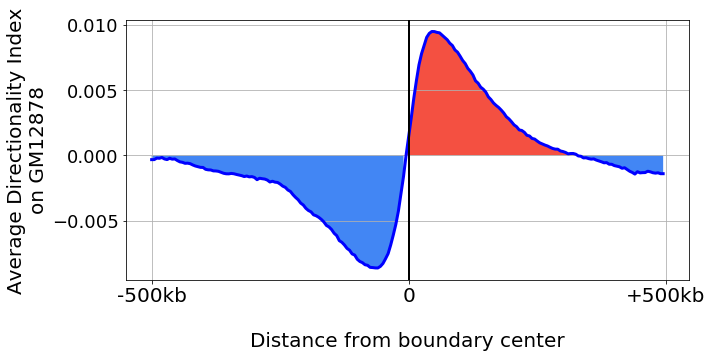

In [69]:
linewidth=3
legendfont = 20
labelfont = 20
tickfont = 20

fig, axes = plt.subplots(1,1,sharex=True,figsize=(10, 5), tight_layout=True)
y = aggregations_by_bound_tot['di_index'].mean(0)
axes.plot(y, linewidth=linewidth, label='both', color='blue')
axes.fill_between(np.arange(y.shape[0]), y, where=y < 0, facecolor='#4286f4')
axes.fill_between(np.arange(y.shape[0]), y, where=y >= 0, facecolor='#f45041')
axes.set_ylabel("Average Directionality Index\non GM12878", fontsize=labelfont)
axes.axvline(extended/window_size, color='black')
axes.grid()
axes.set_xticks([0, extended/window_size, extended*2/window_size])
axes.set_xticklabels(['-500kb', '0', '+500kb'], fontsize=tickfont)
axes.set_xlabel("\nDistance from boundary center", fontsize=labelfont)
# axes.set_ylim(-0.2, 0.2)

# plt.xticks([0, extended/window_size ,extended*2/window_size], labels=['-500kb', 'Boundary center', '+500kb'])
# plt.xlabel("\nPosition", fontsize=20)
# fig.savefig(figure_path / "avg_ctcf_sites_on_bounds_by_window.pdf", bbox_inches='tight', transparent=True)
plt.show()

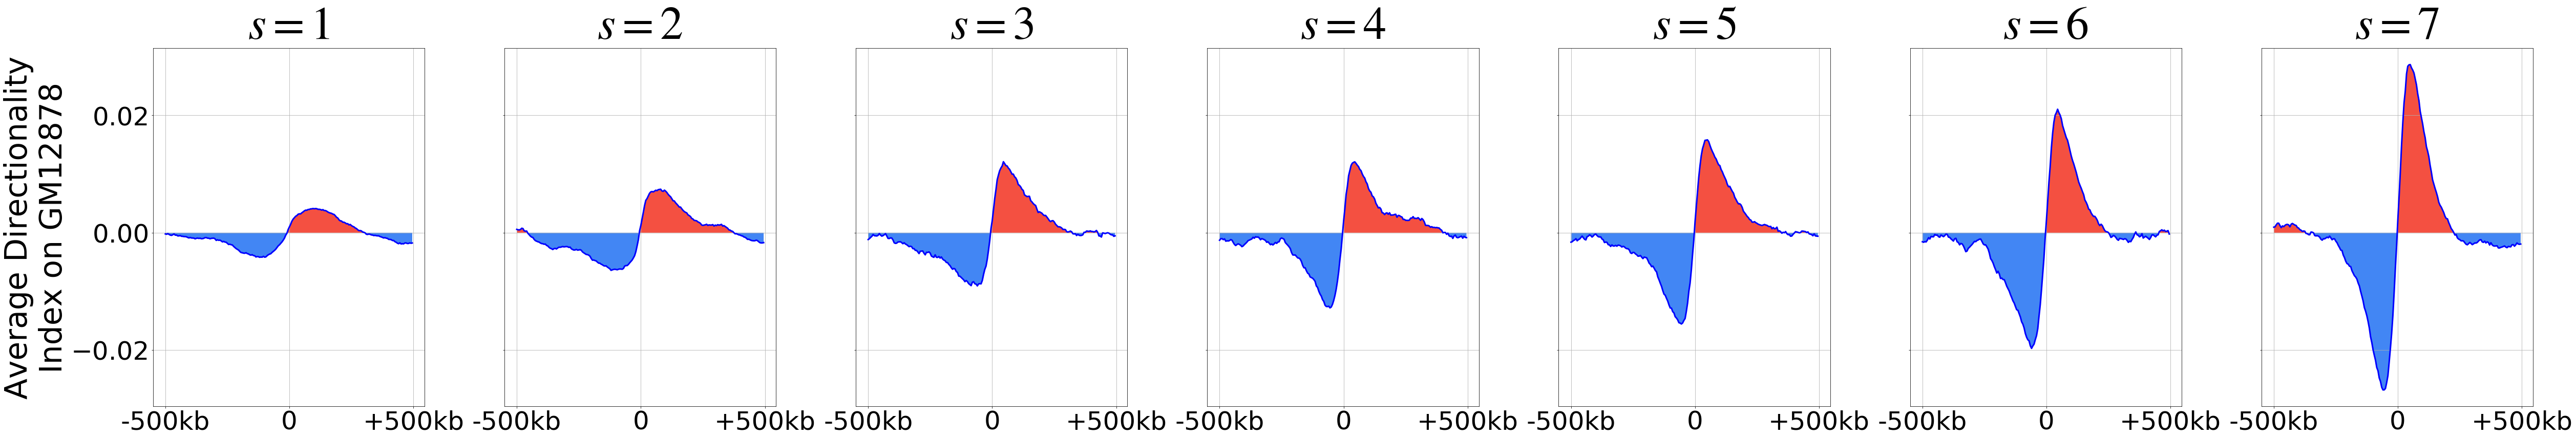

In [71]:
linewidth=3
legendfont = 26
titlefont = 90
labelfont = 60
tickfont = 50

fig, axes = plt.subplots(1,len(windows_with_di.n_cell_types.unique()),sharex='col', sharey=True, tight_layout=True, figsize=(70,12))
for level in sorted(windows_with_di.n_cell_types.unique()):
    y = aggregations_by_bound[(level,'di_index')].mean(0)
    axes[level - 1].plot(y, linewidth=linewidth, color='blue')
    axes[level - 1].fill_between(np.arange(y.shape[0]), y, where=y < 0, facecolor='#4286f4')
    axes[level - 1].fill_between(np.arange(y.shape[0]), y, where=y >= 0, facecolor='#f45041')
    plt.yticks(fontsize=tickfont)
    if level == 1:
        axes[level - 1].set_ylabel("Average Directionality\nIndex on GM12878", fontsize=labelfont)
        axes[level - 1].tick_params(axis='y', which='major', labelsize=tickfont)    # axes[0].axvline(extension/resolution, color='black')
    axes[level - 1].grid()
#     axes[level - 1].legend(loc='upper left', fontsize=legendfont)
    axes[level - 1].set_title("$s = {}$".format(level), fontsize=titlefont, fontweight="bold")
    axes[level - 1].set_xticks([0, extended/window_size, extended*2/window_size])
    yticklabels = axes[level - 1].get_yticklabels()
    axes[level - 1].set_xticklabels(['-500kb', '0', '+500kb'], fontsize=tickfont)
#     axes[level - 1].set_xlabel("\nDistance from boundary center", fontsize=labelfont)
# fig.suptitle("Level {}".format(level), x=0.54, y=1.01, horizontalalignment='center', fontsize=25)
# fig.savefig(figure_path / "avg_ctcf_sites_on_bounds_by_conservation.pdf", bbox_inches='tight', transparent=True)
plt.show()
    

In [48]:
x = axes[level - 1]